In [1]:
from torchvision.datasets import VOCSegmentation
from torchvision.transforms.functional import to_tensor, to_pil_image
from PIL import Image

In [2]:
class myVOCSegmentation(VOCSegmentation):
  def __getitem__(self, index):
      img = Image.open(self.images[index]).convert('RGB')
      target = Image.open(self.masks[index])

      if self.transforms is not None:
          augmented = self.transforms(
              image=np.array(img),
              mask=np.array(target)
          )
          img = augmented['image']
          target = augmented['mask']

      target[target > 20] = 0
      img = to_tensor(img)
      target = torch.from_numpy(target).type(torch.long)

      return img, target

In [3]:
from albumentations import (
    Compose,
    HorizontalFlip,
    Resize,
    Normalize
)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

h, w = 520, 520

transform_train = Compose([
    Resize(height=h, width=w),
    HorizontalFlip(p=0.5),
    Normalize(mean=mean, std=std)
])

transform_val = Compose([
    Resize(height=h, width=w),
    Normalize(mean=mean, std=std)
])

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
path2data = "./data/"

train_ds = myVOCSegmentation(
    path2data,
    year='2012',
    image_set='train',
    download=True,
    transforms=transform_train
)

print(len(train_ds))


100%|██████████| 1999639040/1999639040 [01:15<00:00, 26552586.77it/s]


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data/
1464


In [5]:
val_ds = myVOCSegmentation(
    path2data,
    year='2012',
    image_set='val',
    download=True,
    transforms=transform_val
)

print(len(val_ds))

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data/
1449


In [6]:
import torch
import numpy as np
from skimage.segmentation import mark_boundaries
import matplotlib.pylab as plt
%matplotlib inline

In [7]:
np.random.seed(0)
num_classes = 21
COLORS = np.random.randint(0, 256, size=(num_classes, 3), dtype="uint8")


In [8]:
def show_img_target(img, target):
    if torch.is_tensor(img):
        img = to_pil_image(img)
    target = target.numpy()
    for ll in range(num_classes):
        mask = (target == ll)
        img = mark_boundaries(np.array(img), mask, outline_color=COLORS[ll], color=COLORS[ll])
    plt.imshow(img)

In [9]:
def re_normalize(x, mean=mean, std=std):
    x_r = x.clone()
    for c, (mean_c, std_c) in enumerate(zip(mean, std)):
        x_r[c] *= std_c
        x_r[c] += mean_c
    return x_r

In [10]:
img, mask = train_ds[8]
print(img.shape, img.type(),torch.max(img))
print(mask.shape, mask.type(),torch.max(mask))


torch.Size([3, 520, 520]) torch.FloatTensor tensor(2.6051)
torch.Size([520, 520]) torch.LongTensor tensor(11)


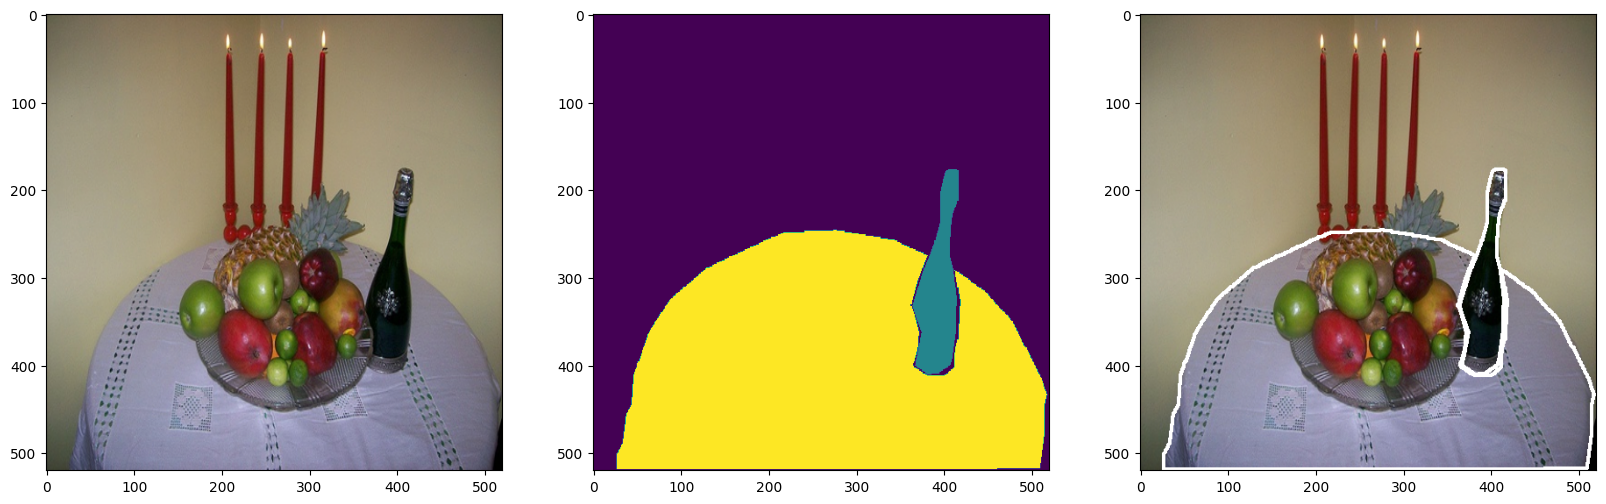

In [11]:
plt.figure(figsize=(20, 20))

img_r = re_normalize(img)

plt.subplot(1, 3, 1)
plt.imshow(to_pil_image(img_r))

plt.subplot(1, 3, 2)
plt.imshow(mask)

plt.subplot(1, 3, 3)
show_img_target(img_r, mask)

plt.show()

In [12]:
img, mask = val_ds[2]
print(img.shape, img.type(),torch.max(img))
print(mask.shape, mask.type(),torch.max(mask))


torch.Size([3, 520, 520]) torch.FloatTensor tensor(2.6226)
torch.Size([520, 520]) torch.LongTensor tensor(4)


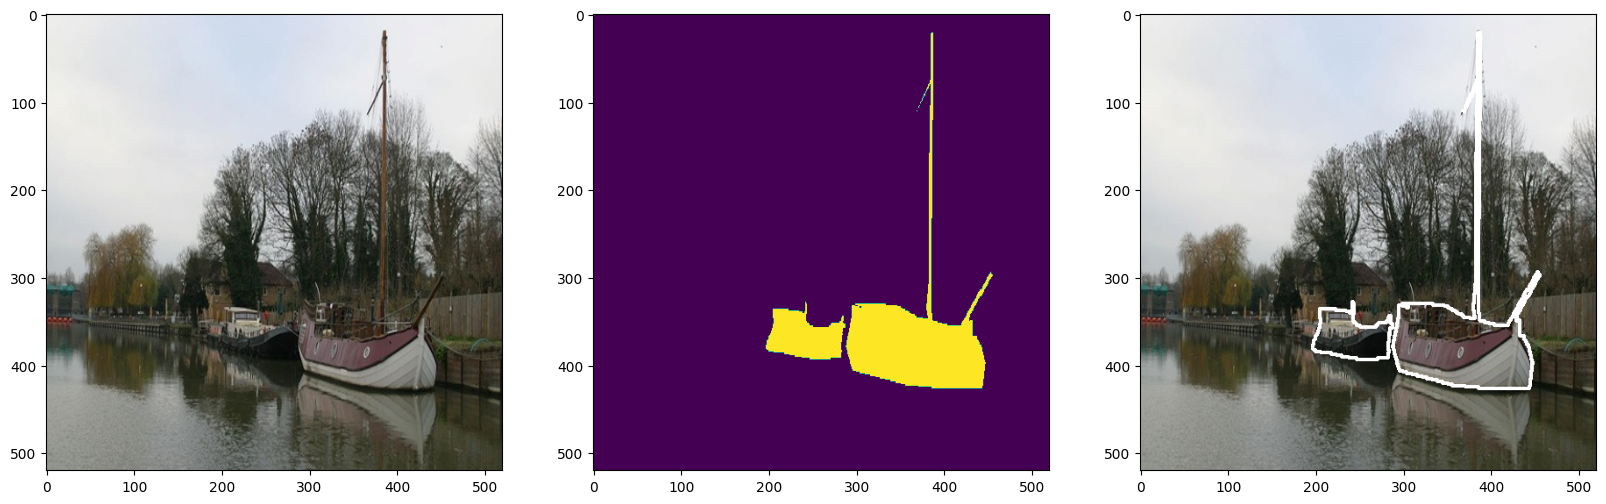

In [13]:
plt.figure(figsize=(20,20))
img_r= re_normalize(img)
plt.subplot(1, 3, 1)
plt.imshow(to_pil_image(img_r))
plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.subplot(1, 3, 3)
show_img_target(img_r, mask)

In [14]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=False)


In [15]:
for img_b, mask_b in train_dl:
    print(img_b.shape, img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break


torch.Size([4, 3, 520, 520]) torch.float32
torch.Size([4, 520, 520]) torch.int64


# **Model construction**

In [16]:
import torch
from torchvision.models.segmentation import deeplabv3_resnet101


In [17]:
model=deeplabv3_resnet101(pretrained=True, num_classes=21)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 153MB/s]


In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else
'cpu')
model=model.to(device)

In [19]:
print(model)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [20]:
from torch import nn

model.eval()
with torch.no_grad():
    for xb, yb in val_dl:
        yb_pred = model(xb.to(device))
        yb_pred = yb_pred["out"].cpu()
        print(yb_pred.shape)
        yb_pred = torch.argmax(yb_pred, axis=1)
        break
print(yb_pred.shape)

torch.Size([8, 21, 520, 520])
torch.Size([8, 520, 520])


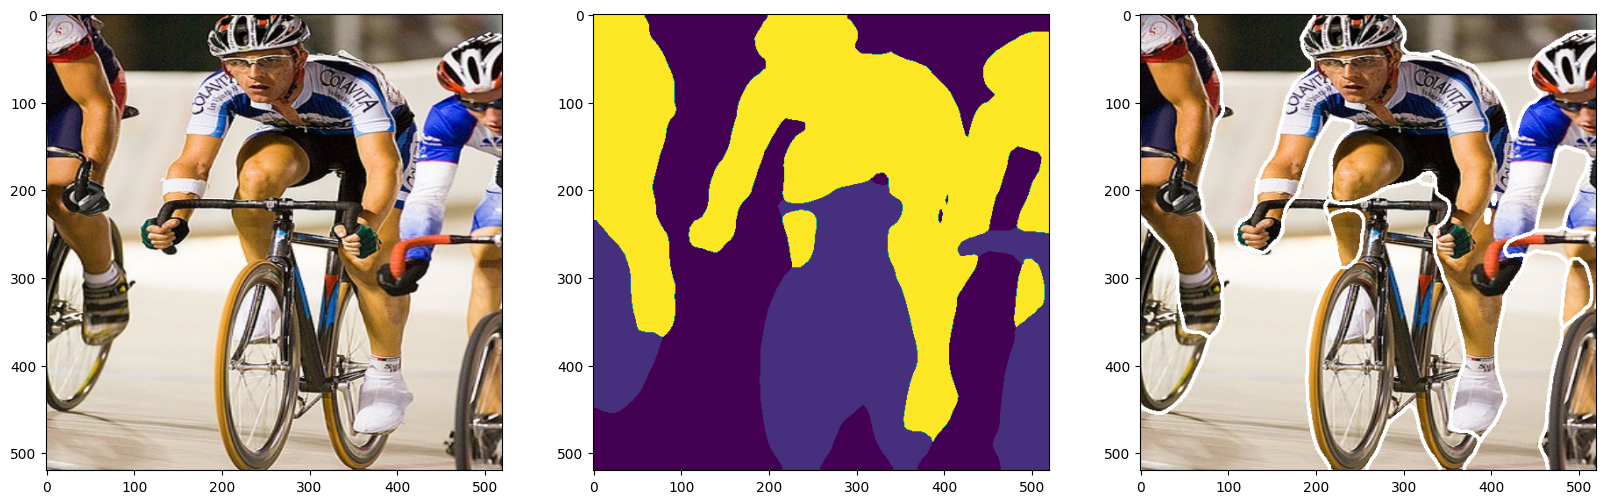

In [21]:
plt.figure(figsize=(20,20))
n=4
img, mask= xb[n], yb_pred[n]
img_r= re_normalize(img)
plt.subplot(1, 3, 1)
plt.imshow(to_pil_image(img_r))
plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.subplot(1, 3, 3)
show_img_target(img_r, mask)


# **The loss function and optimizer**

In [22]:
from torch import nn
criterion = nn.CrossEntropyLoss(reduction="sum")

In [23]:
from torch import optim
opt = optim.Adam(model.parameters(), lr=1e-6)


In [24]:
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), None

In [25]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5,patience=20,verbose=1)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [26]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr = get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=1e-06


# **Training the model**

In [27]:
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    len_data = len(dataset_dl.dataset)
    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)["out"]
        loss_b, _ = loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b
        if sanity_check is True:
            break
    loss = running_loss / float(len_data)
    return loss, None

In [28]:
import copy
def train_val(model, params):
    num_epochs = params["num_epochs"]
    loss_func = params["loss_func"]
    opt = params["optimizer"]
    train_dl = params["train_dl"]
    val_dl = params["val_dl"]
    sanity_check = params["sanity_check"]
    lr_scheduler = params["lr_scheduler"]
    path2weights = params["path2weights"]

    loss_history = {
        "train": [],
        "val": []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))

        model.train()
        train_loss = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history["train"].append(train_loss)

        model.eval()
        with torch.no_grad():
            val_loss = loss_epoch(model, loss_func, val_dl, sanity_check)
            loss_history["val"].append(val_loss)

            if val_loss < best_loss:
                best_loss = val_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), path2weights)
                print("Copied best model weights!")
                lr_scheduler.step(val_loss)

            if current_lr!= get_lr(opt):
                print("Loading best model weights!")
                model.load_state_dict(best_model_wts)
                print("train loss: %.6f" % (train_loss))
                print("val loss: %.6f" % (val_loss))
                print("-"*10)

    return model, loss_history, metric_history

In [ ]:
import os
path2models= "./models/"
if not os.path.exists(path2models):
 os.mkdir(path2models)
params_train={
 "num_epochs": 100,
 "optimizer": opt,
 "loss_func": criterion,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": path2models+"weights.pt",}
model,loss_hist,_=train_val(model,params_train)


In [ ]:
num_epochs=params_train["num_epochs"]
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()
